In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay, precision_recall_curve, f1_score
import numpy as np
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder,StandardScaler, OneHotEncoder,TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')


## Dataset pre-processing, Feature Engineering
To train ML model, I need to clean dataset by getting rid of outliers, missing values. Then split dataset into train and test sets. Use conditions to ensure that proportions of output remain same in both splits.

**Precautions for Modelling Procedure(Based on EDA)**

- **Imbalanced Dataset:**  
    The number of attrited customers is much lower than existing customers (roughly 4:1). This imbalance can bias the model. Techniques like **SMOTE** or class weighting should be applied during training.

- **Card Category Distribution:**  
    Most customers have a Blue Card; higher card categories have very few members. This can affect the model’s ability to generalize for premium segments.

- **Unknown Categories:**  
    The "Unknown" category appears in **Income Category**, **Education Level**, and **Marital Status**. Consider how to handle these missing or ambiguous values (e.g., imputation, separate category). But in all 3 **Unknown Category** can't be dropped as it is 2nd or 3rd highest in churn probabaility in each case

- **Data Anomaly:**  
    A majority of people joined exactly 36 months ago, which is an anomaly in the data. Investigate or consider this during feature engineering.

- **Highly Correlated Features:**  
    **Avg. open to buy** is very similar to **Credit Limit** (perfect linear correlation). Keep only one of these features to avoid multicollinearity.

**Feature Engineering**
***Division Features (A/B):***
These features are ratios, created by dividing one column by another (sometimes adding 1 to the denominator to avoid division by zero). They help capture per-unit relationships, such as:
- Transaction amount per transaction count, revolving balance, open to buy, contacts, inactive months, relationship count, dependent
- Revolving balance per transaction count, contacts, inactive months, relationship count, dependent
- Open to buy per transaction count, contacts, inactive months, relationship count, dependent
- Credit limit per transaction count, contacts, inactive months, relationship count, dependent
- Amount change per transaction count, contacts, inactive months, relationship count, dependent
- Utilization ratio per transaction count, transaction amount, revolving balance, open to buy, credit limit, contacts, inactive months, relationship count, dependent
- Transaction count per revolving balance, open to buy, credit limit, dependent, inactive months, relationship count

***Addition Features (A+B):***
These features are sums, created by adding two columns together. They capture total or combined values, such as:
- Total transaction amount plus revolving balance
- Total transaction amount plus open to buy
- Total transaction amount plus credit limit
- Total revolving balance plus open to buy
- Total revolving balance plus credit limit

These engineered features help the model learn more complex relationships between customer behaviors and churn.




In [79]:
df = pd.read_csv('../data/BankChurners.csv')

In [80]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [81]:
df.drop(columns=['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],inplace=True)

In [82]:
df.isnull().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [84]:
df.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [85]:
df.shape

(10127, 20)

In [86]:
for col in df:
  print(col,df[col].unique())

Attrition_Flag ['Existing Customer' 'Attrited Customer']
Customer_Age [45 49 51 40 44 32 37 48 42 65 56 35 57 41 61 47 62 54 59 63 53 58 55 66
 50 38 46 52 39 43 64 68 67 60 73 70 36 34 33 26 31 29 30 28 27]
Gender ['M' 'F']
Dependent_count [3 5 4 2 0 1]
Education_Level ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']
Marital_Status ['Married' 'Single' 'Unknown' 'Divorced']
Income_Category ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
Card_Category ['Blue' 'Gold' 'Silver' 'Platinum']
Months_on_book [39 44 36 34 21 46 27 31 54 30 48 37 56 42 49 33 28 38 41 43 45 52 40 50
 35 47 32 20 29 25 53 24 55 23 22 26 13 51 19 15 17 18 16 14]
Total_Relationship_Count [5 6 4 3 2 1]
Months_Inactive_12_mon [1 4 2 3 6 0 5]
Contacts_Count_12_mon [3 2 0 1 4 5 6]
Credit_Limit [12691.  8256.  3418. ...  5409.  5281. 10388.]
Total_Revolving_Bal [ 777  864    0 ...  534  476 2241]
Avg_Open_To_Buy [11914.  7392.  3418. ... 11831.  5

In [87]:
df.replace({'Existing Customer':0,'Attrited Customer':1},inplace=True)

In [88]:
df.replace({'M':1,'F':0},inplace=True)

In [89]:
df.dtypes

Attrition_Flag                int64
Customer_Age                  int64
Gender                        int64
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [90]:
categorical_ordinal_features = [
    'Education_Level',
    'Income_Category',
    'Card_Category'
]# That are 
categorical_nominal_features = ['Martial_Status']

In [91]:
# Total_Trans_Amt per other features
df['Trans_Amt_per_Trans_Ct'] = df['Total_Trans_Amt'] / df['Total_Trans_Ct']
df['Trans_Amt_per_Rev_Bal'] = df['Total_Trans_Amt'] / (df['Total_Revolving_Bal'] + 1)
df['Trans_Amt_per_Open_To_Buy'] = df['Total_Trans_Amt'] / (df['Avg_Open_To_Buy'] + 1)
df['Trans_Amt_per_Contacts'] = df['Total_Trans_Amt'] / (df['Contacts_Count_12_mon'] + 1)
df['Trans_Amt_per_Inactive'] = df['Total_Trans_Amt'] / (df['Months_Inactive_12_mon'] + 1)
df['Trans_Amt_per_Relationship'] = df['Total_Trans_Amt'] / (df['Total_Relationship_Count'] + 1)
df['Trans_Amt_per_Dependent'] = df['Total_Trans_Amt'] / (df['Dependent_count'] + 1)
df['Trans_Amt_per_Months_Inactive'] = df['Total_Trans_Amt'] / (df['Months_Inactive_12_mon'] + 1)

# Total_Revolving_Bal per other features
df['Rev_Bal_per_Trans_Ct'] = df['Total_Revolving_Bal'] / df['Total_Trans_Ct']
df['Rev_Bal_per_Contacts'] = df['Total_Revolving_Bal'] / (df['Contacts_Count_12_mon'] + 1)
df['Rev_Bal_per_Inactive'] = df['Total_Revolving_Bal'] / (df['Months_Inactive_12_mon'] + 1)
df['Rev_Bal_per_Relationship'] = df['Total_Revolving_Bal'] / (df['Total_Relationship_Count'] + 1)
df['Rev_Bal_per_Dependent'] = df['Total_Revolving_Bal'] / (df['Dependent_count'] + 1)
df['Rev_Bal_per_Months_Inactive'] = df['Total_Revolving_Bal'] / (df['Months_Inactive_12_mon'] + 1)

# Avg_Open_To_Buy per other features
df['Open_To_Buy_per_Trans_Ct'] = df['Avg_Open_To_Buy'] / df['Total_Trans_Ct']
df['Open_To_Buy_per_Contacts'] = df['Avg_Open_To_Buy'] / (df['Contacts_Count_12_mon'] + 1)
df['Open_To_Buy_per_Inactive'] = df['Avg_Open_To_Buy'] / (df['Months_Inactive_12_mon'] + 1)
df['Open_To_Buy_per_Relationship'] = df['Avg_Open_To_Buy'] / (df['Total_Relationship_Count'] + 1)
df['Open_To_Buy_per_Dependent'] = df['Avg_Open_To_Buy'] / (df['Dependent_count'] + 1)
df['Open_To_Buy_per_Months_Inactive'] = df['Avg_Open_To_Buy'] / (df['Months_Inactive_12_mon'] + 1)

# Credit_Limit per other features
df['Credit_Limit_per_Trans_Ct'] = df['Credit_Limit'] / df['Total_Trans_Ct']
df['Credit_Limit_per_Contacts'] = df['Credit_Limit'] / (df['Contacts_Count_12_mon'] + 1)
df['Credit_Limit_per_Inactive'] = df['Credit_Limit'] / (df['Months_Inactive_12_mon'] + 1)
df['Credit_Limit_per_Relationship'] = df['Credit_Limit'] / (df['Total_Relationship_Count'] + 1)
df['Credit_Limit_per_Dependent'] = df['Credit_Limit'] / (df['Dependent_count'] + 1)
df['Credit_Limit_per_Months_Inactive'] = df['Credit_Limit'] / (df['Months_Inactive_12_mon'] + 1)

# Total_Amt_Chng_Q4_Q1 per other features
df['Amt_Chng_per_Trans_Ct'] = df['Total_Amt_Chng_Q4_Q1'] / df['Total_Trans_Ct']
df['Amt_Chng_per_Contacts'] = df['Total_Amt_Chng_Q4_Q1'] / (df['Contacts_Count_12_mon'] + 1)
df['Amt_Chng_per_Inactive'] = df['Total_Amt_Chng_Q4_Q1'] / (df['Months_Inactive_12_mon'] + 1)
df['Amt_Chng_per_Relationship'] = df['Total_Amt_Chng_Q4_Q1'] / (df['Total_Relationship_Count'] + 1)
df['Amt_Chng_per_Dependent'] = df['Total_Amt_Chng_Q4_Q1'] / (df['Dependent_count'] + 1)
df['Amt_Chng_per_Months_Inactive'] = df['Total_Amt_Chng_Q4_Q1'] / (df['Months_Inactive_12_mon'] + 1)

# Avg_Utilization_Ratio per other features
df['Utilization_per_Trans_Ct'] = df['Avg_Utilization_Ratio'] / df['Total_Trans_Ct']
df['Utilization_per_Trans_Amt'] = df['Avg_Utilization_Ratio'] / df['Total_Trans_Amt']
df['Utilization_per_Rev_Bal'] = df['Avg_Utilization_Ratio'] / (df['Total_Revolving_Bal'] + 1)
df['Utilization_per_Open_To_Buy'] = df['Avg_Utilization_Ratio'] / (df['Avg_Open_To_Buy'] + 1)
df['Utilization_per_Credit_Limit'] = df['Avg_Utilization_Ratio'] / (df['Credit_Limit'] + 1)
df['Utilization_per_Contacts'] = df['Avg_Utilization_Ratio'] / (df['Contacts_Count_12_mon'] + 1)
df['Utilization_per_Inactive'] = df['Avg_Utilization_Ratio'] / (df['Months_Inactive_12_mon'] + 1)
df['Utilization_per_Relationship'] = df['Avg_Utilization_Ratio'] / (df['Total_Relationship_Count'] + 1)
df['Utilization_per_Dependent'] = df['Avg_Utilization_Ratio'] / (df['Dependent_count'] + 1)

# Total_Trans_Ct per other features
df['Trans_Ct_per_Rev_Bal'] = df['Total_Trans_Ct'] / (df['Total_Revolving_Bal'] + 1)
df['Trans_Ct_per_Open_To_Buy'] = df['Total_Trans_Ct'] / (df['Avg_Open_To_Buy'] + 1)
df['Trans_Ct_per_Credit_Limit'] = df['Total_Trans_Ct'] / (df['Credit_Limit'] + 1)
df['Trans_Ct_per_Dependent'] = df['Total_Trans_Ct'] / (df['Dependent_count'] + 1)
df['Trans_Ct_per_Months_Inactive'] = df['Total_Trans_Ct'] / (df['Months_Inactive_12_mon'] + 1)
df['Trans_Ct_per_Relationship'] = df['Total_Trans_Ct'] / (df['Total_Relationship_Count'] + 1)


df['Sum_Trans_Amt_Rev_Bal'] = df['Total_Trans_Amt'] + df['Total_Revolving_Bal']
df['Sum_Trans_Amt_Open_To_Buy'] = df['Total_Trans_Amt'] + df['Avg_Open_To_Buy']
df['Sum_Trans_Amt_Credit_Limit'] = df['Total_Trans_Amt'] + df['Credit_Limit']
df['Sum_Rev_Bal_Open_To_Buy'] = df['Total_Revolving_Bal'] + df['Avg_Open_To_Buy']
df['Sum_Rev_Bal_Credit_Limit'] = df['Total_Revolving_Bal'] + df['Credit_Limit']


In [92]:
X = df.drop(columns='Attrition_Flag')
y = df['Attrition_Flag']

In [93]:
# For linear
one_hot_encode = X.dtypes[X.dtypes == object].index.to_list()
cols_to_scale = X.dtypes[X.dtypes != object].index.to_list()
cols_to_drop = [
    'Avg_Open_To_Buy',
    'Open_To_Buy_per_Trans_Ct',
    'Open_To_Buy_per_Contacts',
    'Open_To_Buy_per_Inactive',
    'Open_To_Buy_per_Relationship',
    'Open_To_Buy_per_Dependent',
    'Open_To_Buy_per_Months_Inactive'
    ]

In [94]:
# For Tree
target_encoding_features = ['Marital_Status']

ordinal_encode = {
    'Education_Level': ['Uneducated',
                        'High School',
                        'College',
                        'Graduate',
                        'Post-Graduate',
                        'Doctorate',
                        'Unknown'],
    'Income_Category': ['Less than $40K',
                        '$40K - $60K',
                        '$60K - $80K',
                        '$80K - $120K',
                        '$120K +',
                        'Unknown'],
    'Card_Category': ['Blue',
                      'Silver',
                      'Gold',
                      'Platinum']
}


In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [96]:
linear_preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), one_hot_encode),
    ('scaler', StandardScaler(), cols_to_scale),
    ('drop', 'drop', cols_to_drop)
])

In [97]:
# 1. Ordinal Encoding
ordinal_features = list(ordinal_encode.keys())
ordinal_order = [ordinal_encode[col] for col in ordinal_features]

# 2. All numeric (no scaling needed)
numeric_features =  X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 3. ColumnTransformer for tree models
tree_preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(categories=ordinal_order), ordinal_features),
    ('target', TargetEncoder(cv=5), target_encoding_features),
    ('passthrough', 'passthrough', numeric_features)
])


## Model Trainning, Tuning
* Trainning multiple models to test and verify the best one, for this case. Further trainning as using LightGBM is best to as it gives best f1 score and roc-auc score.
* Using class weights for optimization due to consideration of data imbalance known from EDA, as balanced weights.
* Using RFE(Recursive Feature Elimination) to eliminate excess features that are that less affect prediction of model.
* Then using Bayesian optmization to optimize hyperparamters for model.This is optional in this case as model has 0.99 rocc-auc score without bayesian optimization. So, I won't be using it.

### Choose Model

In [ ]:
linear_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Linear SVC': LinearSVC(max_iter=10000),
    'KNN': KNeighborsClassifier()
}

tree_models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'LightGBM': LGBMClassifier()
}

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'

    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc if auc=='N/A' else round(auc, 4)}")

    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title("ROC Curve")
        plt.grid()
        plt.show()

    return {
        'F1 Score': f1,
        'ROC AUC': auc if auc != 'N/A' else None
    }


In [ ]:
def run_all_models_with_preprocessors(X_train, X_test, y_train, y_test, models, preprocessor):

    results = {}

    for name, model in models.items():
        print(f"\n🔧 Training: {name}")

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        pipeline.fit(X_train, y_train)

        print("Evaluating...")
        metrics = evaluate_model(pipeline, X_test, y_test)

        results[name] = metrics

    return pd.DataFrame(results).T.sort_values("F1 Score", ascending=False)



Linear Models Evaluation

🔧 Training: Logistic Regression
Evaluating...
Confusion Matrix:
[[1649   52]
 [ 116  209]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1701
           1       0.80      0.64      0.71       325

    accuracy                           0.92      2026
   macro avg       0.87      0.81      0.83      2026
weighted avg       0.91      0.92      0.91      2026

F1 Score: 0.7133
ROC AUC: 0.9393


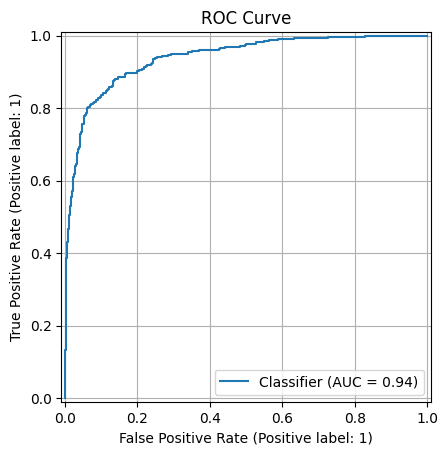


🔧 Training: Linear SVC
Evaluating...
Confusion Matrix:
[[1650   51]
 [ 121  204]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1701
           1       0.80      0.63      0.70       325

    accuracy                           0.92      2026
   macro avg       0.87      0.80      0.83      2026
weighted avg       0.91      0.92      0.91      2026

F1 Score: 0.7034
ROC AUC: N/A

🔧 Training: KNN
Evaluating...
Confusion Matrix:
[[1648   53]
 [  98  227]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1701
           1       0.81      0.70      0.75       325

    accuracy                           0.93      2026
   macro avg       0.88      0.83      0.85      2026
weighted avg       0.92      0.93      0.92      2026

F1 Score: 0.7504
ROC AUC: 0.9385


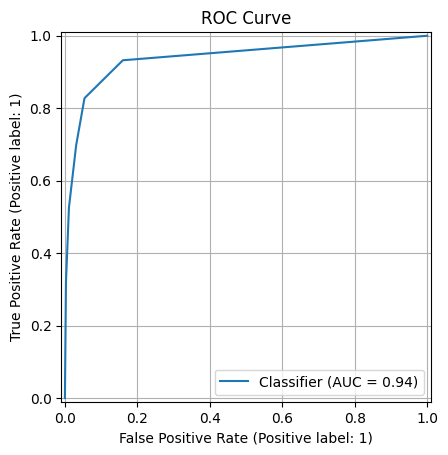


Tree-Based Models Evaluation

🔧 Training: Decision Tree
Evaluating...
Confusion Matrix:
[[1639   62]
 [  73  252]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1701
           1       0.80      0.78      0.79       325

    accuracy                           0.93      2026
   macro avg       0.88      0.87      0.87      2026
weighted avg       0.93      0.93      0.93      2026

F1 Score: 0.7887
ROC AUC: 0.8695


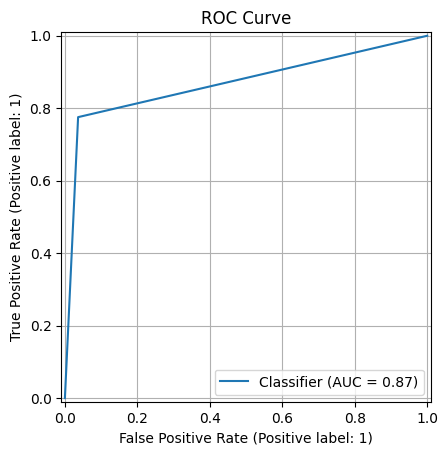


🔧 Training: Random Forest
Evaluating...
Confusion Matrix:
[[1669   32]
 [  61  264]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1701
           1       0.89      0.81      0.85       325

    accuracy                           0.95      2026
   macro avg       0.93      0.90      0.91      2026
weighted avg       0.95      0.95      0.95      2026

F1 Score: 0.8502
ROC AUC: 0.9832


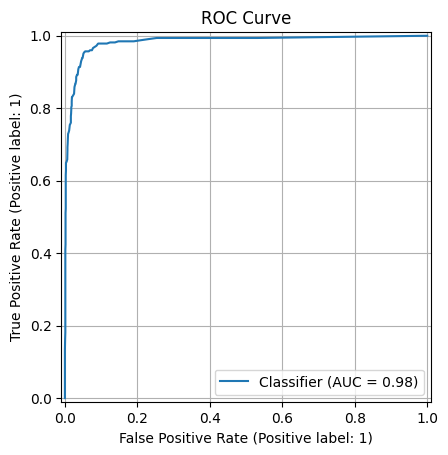


🔧 Training: LightGBM
[LightGBM] [Info] Number of positive: 1302, number of negative: 6799
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15322
[LightGBM] [Info] Number of data points in the train set: 8101, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160721 -> initscore=-1.652874
[LightGBM] [Info] Start training from score -1.652874
Evaluating...
Confusion Matrix:
[[1674   27]
 [  35  290]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.91      0.89      0.90       325

    accuracy                           0.97      2026
   macro avg       0.95      0.94      0.94      2026
weighted avg       0.97      0.97      0.97      2026

F1 Score: 0.9034
ROC AUC: 0.992


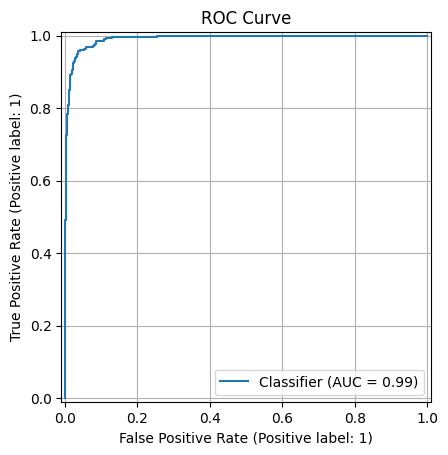

In [ ]:
print("Linear Models Evaluation")
linear_results = run_all_models_with_preprocessors(
    X_train, X_test, y_train, y_test,
    models=linear_models,
    preprocessor=linear_preprocessor
)

print("\nTree-Based Models Evaluation")
tree_results = run_all_models_with_preprocessors(
    X_train, X_test, y_train, y_test,
    models=tree_models,
    preprocessor=tree_preprocessor
)


### Recursive Feature Elimination

In [102]:
COST_FN = 1000  # False Negative: Missed churners
COST_FP = 100   # False Positive: Incorrectly targeted loyal users

def find_optimal_threshold(y_true, y_probs, cost_fn=COST_FN, cost_fp=COST_FP):
    thresholds = np.arange(0.01, 0.99, 0.01)
    costs = []
    for t in thresholds:
        y_pred = (y_probs > t).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        
        # [TN, FP], [FN, TP]
        fn = cm[1, 0]
        fp = cm[0, 1]
        total_cost = (fn * cost_fn) + (fp * cost_fp)
        
        costs.append((t, total_cost))

    cost_df = pd.DataFrame(costs, columns=['Threshold', 'Total_Cost'])
    best_row = cost_df.loc[cost_df['Total_Cost'].idxmin()]
    
    return best_row, cost_df

In [ ]:
cost_optim_df = pd.DataFrame(columns=['Threshold','Min_Cost','N_features'])
for num_features in range(1,len(X_train)+1):
    if num_features%5==0: print(f'{num_features}/{len(X_train)} iterations')    
    X_train_tree = tree_preprocessor.fit_transform(X_train, y_train)
    X_test_tree = tree_preprocessor.transform(X_test)
    model_weighted = LGBMClassifier(
        class_weight='balanced'
    )
    rfe = RFE(estimator=model_weighted, n_features_to_select=num_features)
    rfe.fit(X_train_tree, y_train)
    selected_indices = [X.columns.get_loc(f) for f in selected_features]

    X_train_selected = X_train_tree[:, selected_indices]
    X_test_selected = X_test_tree[:, selected_indices]

    model_weighted.fit(X_train_selected, y_train)
    # Use your best model to get predicted probabilities
    y_probs = model_weighted.predict_proba(X_test_selected)[:, 1]

    # Find best threshold
    best_row, cost_report_df = find_optimal_threshold(y_test, y_probs)
    # Add row to cost_optim_df with threshold, min cost, and number of features
    cost_optim_df = pd.concat([
        cost_optim_df,
        pd.DataFrame({
            'Threshold': [best_row['Threshold']],
            'Min_Cost': [best_row['Total_Cost']],
            'N_features': [num_features]
        })
    ], ignore_index=True)


[LightGBM] [Info] Number of positive: 1302, number of negative: 6799
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15322
[LightGBM] [Info] Number of data points in the train set: 8101, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1302, number of negative: 6799
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15316
[LightGBM] [Info] Number of data points in the train set: 8101, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Nu

In [ ]:
cost_optim_df[cost_optim_df['Min_Cost'].idxmin()]

In [ ]:
# Get mask and selected features
selected_features = X.columns[rfe.support_].tolist()
print("Selected Features:")
print(selected_features)

Selected Features:
['Education_Level', 'Marital_Status', 'Months_on_book', 'Total_Relationship_Count', 'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Trans_Amt_per_Trans_Ct', 'Trans_Amt_per_Rev_Bal', 'Trans_Amt_per_Open_To_Buy', 'Trans_Amt_per_Contacts', 'Trans_Amt_per_Inactive', 'Trans_Amt_per_Relationship', 'Trans_Amt_per_Dependent', 'Rev_Bal_per_Contacts', 'Rev_Bal_per_Inactive', 'Rev_Bal_per_Relationship', 'Open_To_Buy_per_Trans_Ct', 'Open_To_Buy_per_Contacts', 'Open_To_Buy_per_Inactive', 'Credit_Limit_per_Trans_Ct', 'Credit_Limit_per_Inactive', 'Credit_Limit_per_Relationship', 'Credit_Limit_per_Dependent', 'Amt_Chng_per_Trans_Ct', 'Amt_Chng_per_Contacts', 'Amt_Chng_per_Inactive', 'Amt_Chng_per_Relationship', 'Amt_Chng_per_Dependent', 'Utilization_per_Relationship', 'Trans_Ct_per_Rev_Bal', 'Trans_Ct_per_Dependent', 'Trans_Ct_per_Months_Inactive', 'Trans_Ct_per_Relationship', 'Sum_Trans_Amt_Rev_Bal

In [ ]:
cost_report_df

,Threshold,Total_Cost
0,0.01,30000
1,0.02,23100
2,0.03,21600
3,0.04,20300
4,0.05,18800
...,...,...
93,0.94,88500
94,0.95,93500
95,0.96,104500
96,0.97,112400


## Model Report

In [ ]:
COST_FN = 1000  # False Negative: Missed churners
COST_FP = 100   # False Positive: Incorrectly targeted loyal users

def find_optimal_threshold(y_true, y_probs, cost_fn=COST_FN, cost_fp=COST_FP):
    thresholds = np.arange(0.01, 0.99, 0.01)
    costs = []
    for t in thresholds:
        y_pred = (y_probs > t).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        
        # [TN, FP], [FN, TP]
        fn = cm[1, 0]
        fp = cm[0, 1]
        total_cost = (fn * cost_fn) + (fp * cost_fp)
        
        costs.append((t, total_cost))

    cost_df = pd.DataFrame(costs, columns=['Threshold', 'Total_Cost'])
    best_row = cost_df.loc[cost_df['Total_Cost'].idxmin()]
    
    return best_row, cost_df


Best Threshold: 0.1
    Threshold  Total_Cost
0        0.01       30000
1        0.02       23100
2        0.03       21600
3        0.04       20300
4        0.05       18800
..        ...         ...
93       0.94       88500
94       0.95       93500
95       0.96      104500
96       0.97      112400
97       0.98      129200

[98 rows x 2 columns]
Threshold         0.1
Total_Cost    15100.0
Name: 9, dtype: float64


C:\Users\amogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


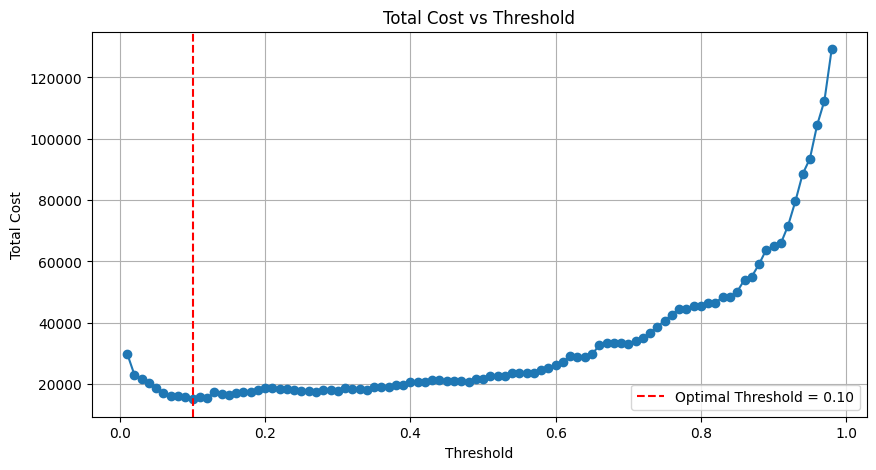

In [71]:
print(f"Best Threshold: {round(best_thresh, 3)}")
print(cost_report_df)
print(best_row)
plt.figure(figsize=(10, 5))
plt.plot(cost_report_df['Threshold'], cost_report_df['Total_Cost'], marker='o')
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Optimal Threshold = {best_thresh:.2f}')
plt.title("Total Cost vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.grid(True)
plt.legend()
plt.show()

C:\Users\amogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


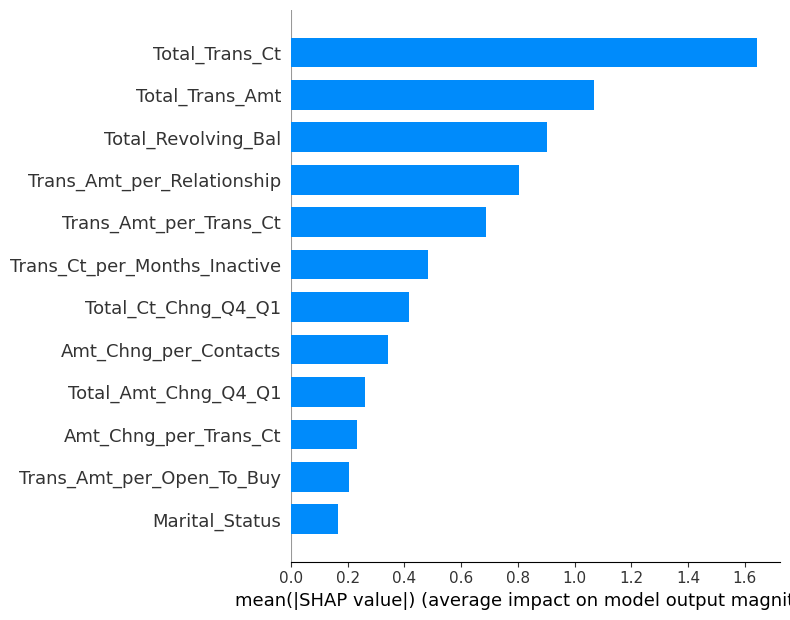

In [55]:
# Use selected_features as feature names for SHAP summary plot
explainer = shap.TreeExplainer(model_weighted)
shap_values = explainer.shap_values(X_test_selected)

if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_test_selected, feature_names=selected_features, plot_type="bar")
else:
    shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features, plot_type="bar")

In [56]:
# Save model
joblib.dump(model_weighted, '../model/churn_model.pkl')

# Save feature order (important when serving from dict inputs in API)
feature_order = X_train.columns.tolist()
with open('../model/feature_order.json', 'w') as f:
    json.dump(selected_features, f)